<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-и-разделение-данных" data-toc-modified-id="Подготовка-и-разделение-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка и разделение данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Константная модель</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

# метрики
from sklearn.metrics import mean_squared_error

# кросс-валидация
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

# модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

# отключение предупреждений
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# сделаем столбец 'datetime' индексом и переведем его в формат даты
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# проверим временную последовательность на монотонность 
display(data.index.is_monotonic)

# проверим временную последовательность на повторы
display(data.index.is_unique)

True

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

---------------------------------------------------------------------------


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

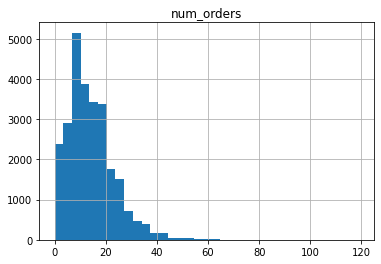

In [4]:
display(data.head())

display(data.describe().T)
print('-' * 75)

display(data.info())
print('-' * 75)

display(data.hist(bins=35))

<div style="border:solid silver 2px; padding: 30px">
    
* Всего в датасете 26 496 наблюдений с 1 марта по 31 августа 2018 года и 1 колонка с информацией о числе заказов, которая является целевым признаком
* Наблюдения загружены с периодичностью в 10 минут, нужно сделать ресемплирование по одному часу, а также суммировать количество заказов
* Минимальное число заказов - 0, максимальное - 119, среднее - 14. Основная доля заказов, судя по графику, приходится на диапазон от 0 до 20, и далее идет на спад
* Пропусков не наблюдается, столбец **num_orders** придерживается стиля snake_case, тип данных - целочисленный, все корректно

In [5]:
# сохраним кол-во строк до ресемплирования
data_shape_before = data.shape[0]

# делаем ресемплирование по 1 часу и суммируем заказы
data = data.resample('1H').sum()

# проверяем
print(f'Количество строк сократилось в {data_shape_before // data.shape[0]} раз')
display(data.head())

Количество строк сократилось в 6 раз


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [6]:
def make_plot(df, title, xlabel='', ylabel=''):
    plt.rc('font', size=12)
    df.plot(figsize=(16, 5), ax=plt.gca())
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

Теперь более подробно рассмотрим имеющиеся данные. Чтобы снизить колебания во временном ряду добавим скользящее среднее и стандартное отклонение и совместим их показатели на графике

Размер окна будет 24*7, чтобы получить сглаженную линию

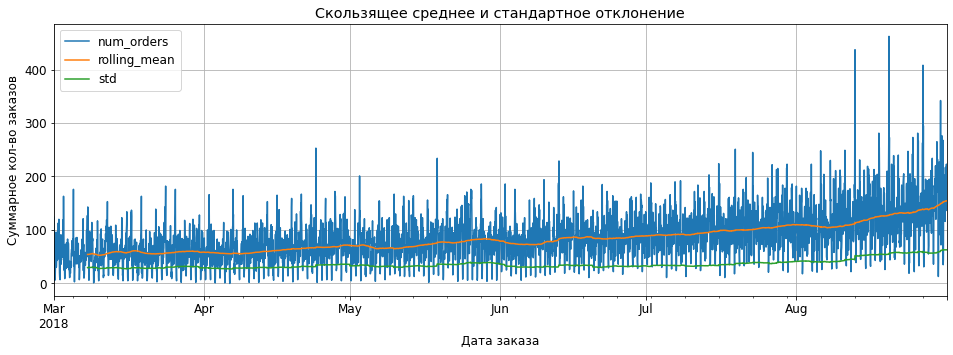

In [7]:
# скользящее среднее
data['rolling_mean'] = data['num_orders'].rolling(24*7).mean()
# скользящее стандартное отклонение
data['std'] = data['num_orders'].rolling(24*7).std()

make_plot(data, 'Скользящее среднее и стандартное отклонение',
          'Дата заказа', 'Суммарное кол-во заказов')

Ряд является стационарным, когда в течение времени количество событий изменяется равномерно. Например, ночью всегда поступает 10 заказов такси, а в полдень – 100.

В данном случае временной ряд нестационарный – количество заказов постепенно растет

Далее разложим временной ряд на три составляющие: тренд, сезонность и остаток и рассмотрим их на графиках

In [8]:
decomposed = seasonal_decompose(data['num_orders'])

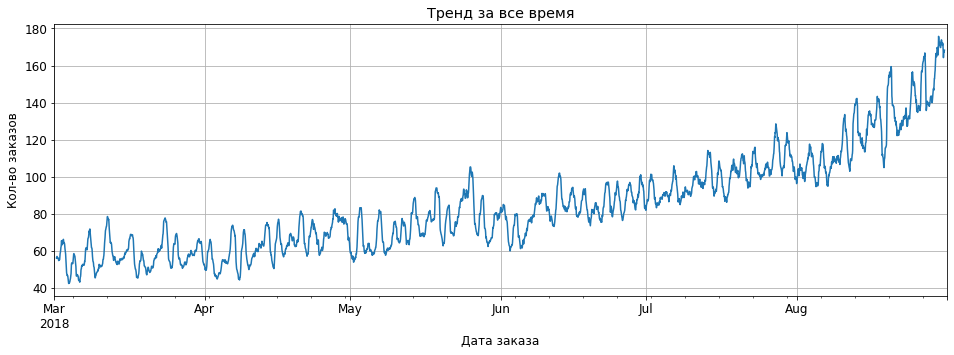

In [9]:
make_plot(decomposed.trend, 'Тренд за все время', 'Дата заказа', 'Кол-во заказов')

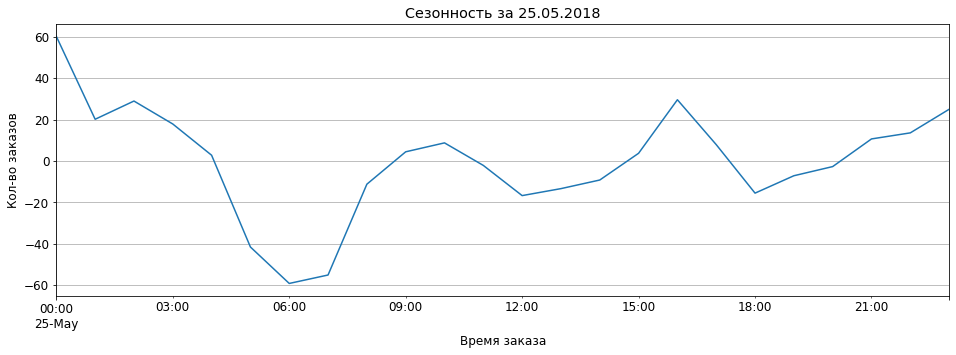

In [10]:
make_plot(decomposed.seasonal['2018-05-25'], 'Сезонность за 25.05.2018', 'Время заказа', 'Кол-во заказов')

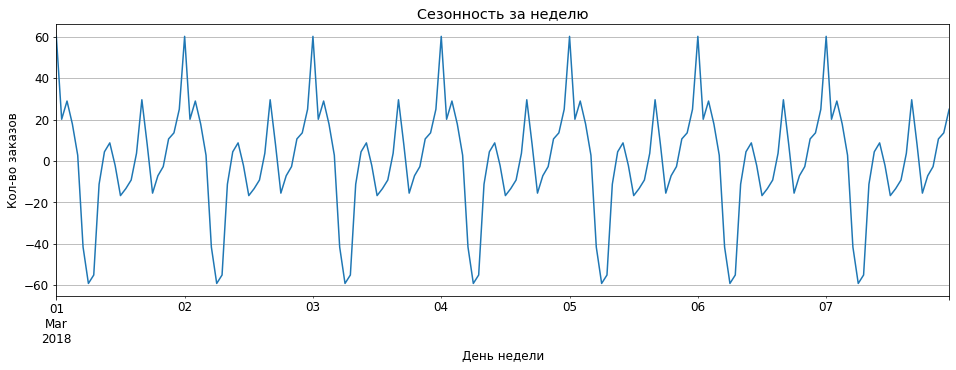

In [11]:
make_plot(decomposed.seasonal.head(24*7), 'Сезонность за неделю', 'День недели', 'Кол-во заказов')

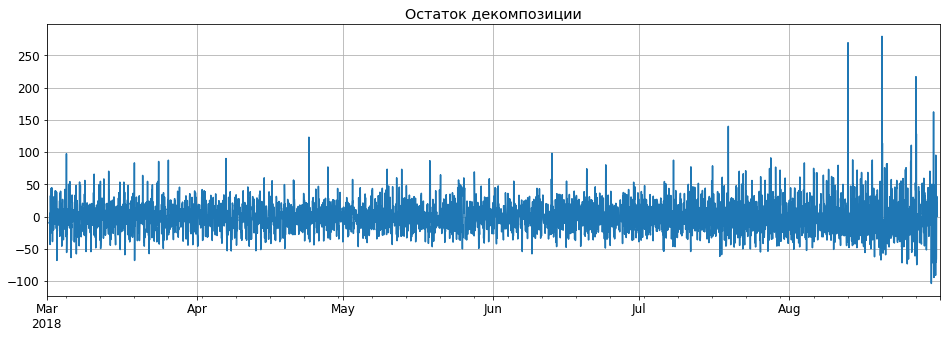

In [12]:
make_plot(decomposed.resid, 'Остаток декомпозиции') 

In [13]:
# убираем созданные столбцы
data = data.drop(['rolling_mean', 'std'], axis=1)

<div style="border:solid silver 2px; padding: 30px">

* Наблюдается суточная сезонность – ежедневно с утра начинается рост заказов, в течение дня и к вечеру кол-во заказов достигает пика и далее идет на спад
* Тренд плавно растущий, похоже, что компания «Чётенькое такси» набирает популярность. С июля кол-во заказов растёт быстрее, возможно в это время проводилась рекламная кампания для привлечения новых пассажиров

## Обучение

### Подготовка и разделение данных

In [14]:
# зафиксируем значение random state
SEED = 12345

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Количество лагов и размер окна поставим 168, т.е. 24*7, чтобы модель учитывала сезонность в данных на уровне недели

In [16]:
# создадим новые признаки
make_features(data, 168, 168)

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# удалим пропущенные значения
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

# проверим, что данные в обучающем и тестовом наборе не пересекаются
print(target_train.index.max(), target_test.index.min())

2018-08-13 13:00:00 2018-08-13 14:00:00


In [18]:
# зафиксируем кол-во сплитов
TSCV = TimeSeriesSplit(n_splits=10)

In [19]:
# создадим функцию для кросс-валидации

rmse_model = []

def make_randomizedsearch(model, parameters):
    
    model = RandomizedSearchCV(model,
                               parameters,
                               random_state=SEED,
                               cv=TSCV,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1)
    
    model.fit(features_train, target_train)
    
    rmse = round(abs(model.best_score_), 2)
    
    rmse_model.append(rmse)
    
    print(model.best_params_)
    print(f'RMSE: {rmse}')
    print()

### Линейная регрессия

In [20]:
%%time

model_lr = LinearRegression()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

make_randomizedsearch(model_lr, parameters)

{'normalize': True, 'fit_intercept': False}
RMSE: 23.26

CPU times: user 7.92 s, sys: 9.13 s, total: 17.1 s
Wall time: 17 s


### Случайный лес

In [21]:
%%time

model_rf = RandomForestRegressor(random_state=SEED)

parameters = {
    'max_depth': [2, 7],
    'n_estimators': [50, 100, 200, 250],
    'max_features': [3, 5, 7],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4]
}

make_randomizedsearch(model_rf, parameters)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 7}
RMSE: 25.88

CPU times: user 31.4 s, sys: 0 ns, total: 31.4 s
Wall time: 31.5 s


### LightGBM

In [22]:
%%time

model_lgbm = LGBMRegressor(random_state=SEED)

parameters = {
    'max_depth': [2, 7],
    'n_estimators': [50, 100, 200, 250],
    'boosting_type': ['gbdt', 'dart', 'goss']
}

make_randomizedsearch(model_lgbm, parameters)

{'n_estimators': 250, 'max_depth': 2, 'boosting_type': 'gbdt'}
RMSE: 22.01

CPU times: user 20min 11s, sys: 9.61 s, total: 20min 21s
Wall time: 20min 30s


In [23]:
compare = pd.DataFrame(
    rmse_model,
    index = ['Линейная регрессия', 'Случайный лес', 'LightGBM'],
    columns =['Значение RMSE']
)

compare

,Значение RMSE
Линейная регрессия,23.26
Случайный лес,25.88
LightGBM,22.01


<div style="border:solid silver 2px; padding: 30px">

* На обучающих данных все модели хорошо себя показали и по значению RMSE идут практически наравне.
* Модель LightGBM показала самую маленькую RMSE – 22.01, поэтому проверим её на тестовых данных и сравним с константной моделью
* Также стоит проверить на тестовом наборе и линейную регрессию, она хоть и немного отстает по показателям от бустинга, но по скорости является победителем

## Тестирование

In [24]:
rmse_model = []

### Линейная регрессия

In [1]:
%%time

model_lr = LinearRegression(normalize=True, fit_intercept=False)

start = time.time()
model_lr.fit(features_train, target_train)
train_time_lr = round(time.time() - start, 2)

start = time.time()
predict_lr = model_lr.predict(features_test)
pred_time_lr = round(time.time() - start, 2)

# вычисляем RMSE
rmse_lr = mean_squared_error(target_test, predict_lr)**0.5
rmse_model.append(rmse_lr)

print(f'RMSE: {rmse_lr}')
print()

NameError: name 'LinearRegression' is not defined

### LightGBM

In [26]:
%%time

model_lgbm = LGBMRegressor(random_state=SEED, n_estimators=50, max_depth=7, boosting_type='goss')
model_lgbm.fit(features_train, target_train)
predict_lgbm = model_lgbm.predict(features_test)

# вычисляем RMSE
rmse_lgbm = mean_squared_error(target_test, predict_lgbm)**0.5
rmse_model.append(rmse_lgbm)

print(f'RMSE: {rmse_lgbm}')
print()

RMSE: 37.62556199873762

CPU times: user 1.51 s, sys: 63.2 ms, total: 1.58 s
Wall time: 1.6 s


### Константная модель

In [27]:
%%time

const_model = DummyRegressor(strategy='mean')
const_model.fit(features_train, target_train)

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

# вычисляем RMSE
rmse_cm = mean_squared_error(target_test, pred_previous)**0.5
rmse_model.append(rmse_cm)

print(f'RMSE: {rmse_cm}')
print()

RMSE: 58.856486242815066

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 1.53 ms


In [28]:
compare = pd.DataFrame(
    rmse_model,
    index = ['Линейная регрессия', 'LightGBM', 'Константная модель'],
    columns =['Значение RMSE']
)

compare

,Значение RMSE
Линейная регрессия,34.396381
LightGBM,37.625562
Константная модель,58.856486


<div style="border:solid silver 2px; padding: 30px">
    
* Все модели успешно прошли проверку на адекватность
* Здесь явным победителем оказалась линейная регрессия, но стоит отметить, что LightGBM с гиперпараметрами {'n_estimators': 250, 'max_depth': 2, 'boosting_type': 'gbdt'} тоже является достойным выбором

## Общий вывод

<div style="border:solid silver 2px; padding: 30px">
    
* Компании «Чётенькое такси» можем порекомендовать модель линейной регрессии с гиперпараметрами {'normalize': True, 'fit_intercept': False}, которая показала себя лучше градиентного бустинга по значению RMSE на тестовой выборке, а также достигла значения RMSE не более 48 на тестовой выборке, а именно 34

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48